In [ ]:
# Baseline Model: ARMA model, NVDA spot price, has logarithmic and exponential scale settings.

ARMA model for NVDA spot price:
Scrape using Beautiful Soup, display using Pandas

In [4]:
# Imports
# To import, run "conda install -c conda-forge <package1> <package2>" in the Anaconda prompt
import os
import lxml
import pandas as pd
from bs4 import BeautifulSoup
from scipy import stats, signal
from scipy.optimize import minimize
import yfinance as yf
import datetime as dt
from datetime import date, datetime, timedelta
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
import quantstats as qs

# Magic function to enable matplotlib charting in jupyter notebooks
%matplotlib inline

In [8]:
def base_ar(prices, time, exp_decay=None, log_base=None):
    """
    Custom autoregressive model with settings for exponential weighting and logarithmic scaling
    
    Parameters:
    prices (Series): Historical closing prices
    time (int): Number of lags to use in AR model
    exp_decay (float or None): Exponential decay factor (0-1), None for no weighting
    log_base (float or None): Base of logarithm to use, None for no transformation
    
    Returns:
    tuple: (coefficients, residuals, use_log, log_base)
    """
    # Determine whether to use log transformation
    use_log = log_base is not None
    
    # Apply logarithmic transformation if specified
    if use_log:
        if log_base == np.e:
            transformed_prices = np.log(prices)
        else:
            transformed_prices = np.log(prices) / np.log(log_base)
        print(f"Applied logarithmic transformation with base {log_base}")
    else:
        transformed_prices = prices.copy()
    
    # Create design matrix and target
    X = np.zeros((len(transformed_prices) - time, time + 1))
    y = transformed_prices[time:].values
    
    # Fill in X with lags and constant term
    X[:, 0] = 1  # Constant term
    for i in range(len(transformed_prices) - time):
        X[i, 1:] = transformed_prices[i:i+time].values
    
    # Determine whether to use exponential weighting
    use_exp_weights = exp_decay is not None
    
    # Apply exponential weighting if specified
    weights = np.ones(time + 1)
    if use_exp_weights:
        # Calculate weights for each lag (more recent = higher weight)
        weights[0] = 1  # Don't weight the intercept
        for i in range(1, time + 1):
            # Weights decrease exponentially as lags increase
            # Most recent observation (last lag) has weight 1
            weights[i] = exp_decay ** (time - i)
        
        # Create weighted version of X for fitting
        weighted_X = X.copy()
        for i in range(1, time + 1):
            weighted_X[:, i] = X[:, i] * weights[i]
        
        print(f"Applied exponential weighting with decay factor {exp_decay}")
        print(f"Weight range: {weights[1:].min():.4f} to {weights[1:].max():.4f}")
        
        # Use weighted X for fitting
        X_for_fitting = weighted_X
    else:
        X_for_fitting = X
    
    # Fit AR model using Ordinary Least Squares
    coefficients = np.linalg.lstsq(X_for_fitting, y, rcond=None)[0]
    
    # Calculate fitted values (use original X to get actual fitted values)
    fitted = np.dot(X, coefficients)
    
    # Calculate residuals
    residuals = y - fitted
    
    # Print coefficients
    model_type = []
    if use_exp_weights:
        model_type.append("Exponentially Weighted")
    if use_log:
        model_type.append("Log Scale")
    
    model_desc = " - ".join(["AR({})".format(time)] + model_type)
    print(f"{model_desc} Coefficients:")
    print(f"Intercept: {coefficients[0]:.4f}")
    
    for i in range(1, len(coefficients)):
        weight_info = f" (weight: {weights[i]:.4f})" if use_exp_weights else ""
        print(f"Week {i}: {coefficients[i]:.4f}{weight_info}")
    
    return coefficients, residuals, use_log, log_base

In [9]:
def base_ar_predict(prices, model_results, k=3):
    """
    Predict future values using the base AR model
    
    Parameters:
    prices (Series): Historical closing prices
    model_results: Tuple of (coefficients, residuals, use_log, log_base)
    k (int): Number of periods to forecast
    
    Returns:
    DataFrame: Predictions with confidence intervals
    """
    coefficients, residuals, use_log, log_base = model_results
    
    # Apply logarithmic transformation if the model used it
    if use_log:
        if log_base == np.e:
            transformed_prices = np.log(prices)
        else:
            transformed_prices = np.log(prices) / np.log(log_base)
    else:
        transformed_prices = prices.copy()
    
    # Calculate residual standard error for prediction intervals
    residual_std = np.std(residuals)
    z = 1.96  # 95% confidence interval
    
    # Get model parameters
    lags = len(coefficients) - 1
    recent_prices = transformed_prices[-lags:].values
    
    # Initialize prediction arrays
    predictions = []
    lower_bounds = []
    upper_bounds = []
    
    # Generate forecasts
    for i in range(k):
        # Calculate next value
        next_price = coefficients[0]  # Intercept
        for j in range(lags):
            if i + j < lags:
                # Using historical data
                next_price += coefficients[j+1] * recent_prices[-(lags-j)]
            else:
                # Using previously predicted values
                next_price += coefficients[j+1] * predictions[i+j-lags]
        
        # Calculate prediction interval
        prediction_error = z * residual_std
        lower_bound = next_price - prediction_error
        upper_bound = next_price + prediction_error
        
        # Store predictions
        predictions.append(next_price)
        lower_bounds.append(lower_bound)
        upper_bounds.append(upper_bound)
    
    # Transform predictions back to original scale if logarithmic transformation was used
    if use_log:
        if log_base == np.e:
            predictions = np.exp(predictions)
            lower_bounds = np.exp(lower_bounds)
            upper_bounds = np.exp(upper_bounds)
        else:
            predictions = log_base ** np.array(predictions)
            lower_bounds = log_base ** np.array(lower_bounds)
            upper_bounds = log_base ** np.array(upper_bounds)
    
    # Create date range for predictions
    last_date = prices.index[-1]
    pred_dates = pd.date_range(start=last_date + pd.Timedelta(days=0), 
                              periods=k, 
                              freq='W-FRI')
    
    # Create results DataFrame
    results = pd.DataFrame({
        'Prediction': predictions,
        'Lower_Bound': lower_bounds,
        'Upper_Bound': upper_bounds
    }, index=pred_dates)
    
    return results

In [10]:
nvda = yf.Ticker("NVDA")
data = nvda.history(period="5y", interval="1wk")
close_prices = data['Close']

In [14]:
# Original AR model
'''
Example calls:
c, r, ul, lb = base_ar(close_prices, time=20)
c, r, ul, lb = base_ar(close_prices, time=20, log_base=np.e)
c, r, ul, lb = base_ar(close_prices, time=20, exp_decay=0.85, log_base=10)
'''
print("\n1. Autoregression:")
c, r, ul, lb = base_ar(close_prices, time=20)
price_pred = base_ar_predict(close_prices, (c, r, ul, lb), k=3)
print("\n Model Prediction:")
print(price_pred)


1. Regular autoregression:
AR(20) Coefficients:
Intercept: 0.5508
Week 1: -0.2168
Week 2: 0.0184
Week 3: 0.3299
Week 4: -0.3516
Week 5: 0.2201
Week 6: -0.0757
Week 7: -0.0297
Week 8: 0.1005
Week 9: -0.1663
Week 10: 0.1303
Week 11: 0.0746
Week 12: 0.1010
Week 13: -0.1169
Week 14: -0.1581
Week 15: 0.1643
Week 16: -0.1784
Week 17: 0.1818
Week 18: 0.0393
Week 19: -0.0361
Week 20: 0.9562

 Model Prediction:
                           Prediction  Lower_Bound  Upper_Bound
2025-03-07 00:00:00-05:00  112.839087   105.220661   120.457513
2025-03-14 00:00:00-04:00  112.981647   105.363221   120.600073
2025-03-21 00:00:00-04:00  113.553593   105.935167   121.172018


<Figure size 1008x576 with 0 Axes>

<Figure size 1008x576 with 0 Axes>

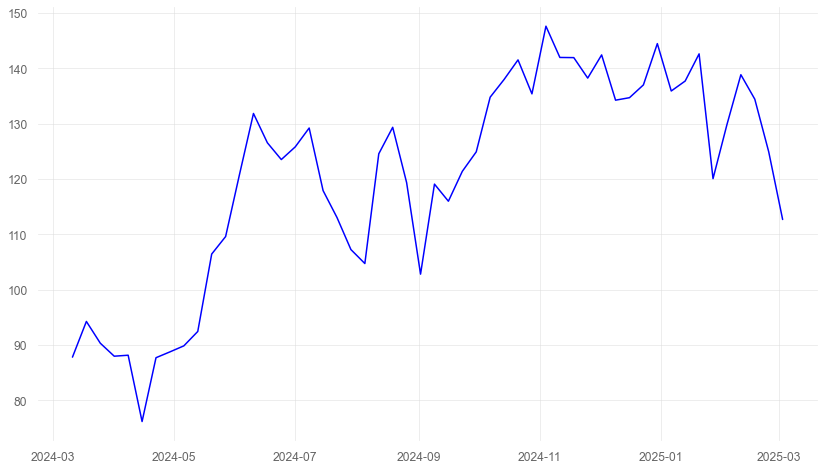

In [19]:
# Plot historical prices (last year)
plt.figure(figsize=(14, 8))
plt.plot(close_prices.index[-52:], close_prices.values[-52:], 
         label='Historical Close Prices', color='blue')

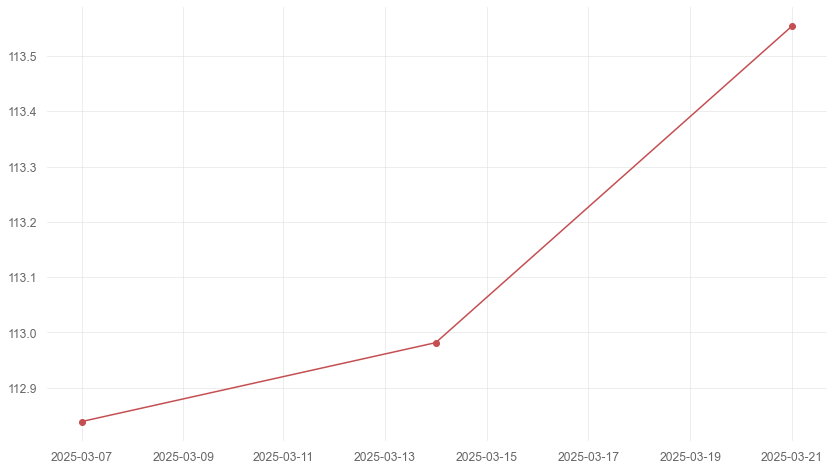

In [26]:
# Plot predicted prices (next k weeks)
plt.figure(figsize=(14, 8))
plt.plot(price_pred.index, price_pred['Prediction'], 'ro-')